9.6 동태적 넬슨-시겔 모형과 2020년 12월까지의 월별자료를 이용해서 사후 샘플링을 실시한 다음

(a) 파라미터의 사후 분포 추정결과를 제시하시오

(b) 2021년 1월의 사후 예측 밀도를 계산하는 과정을 설명하고 실제로 계산한 결과를 나타내시오

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import invgamma, invwishart, multivariate_normal
from scipy.linalg import solve_discrete_lyapunov
from tqdm import tqdm

from matplotlib import rc
rc('font', family='AppleGothic') 			
plt.rcParams['axes.unicode_minus'] = False

In [3]:
bond_yield=pd.read_csv('./data/korea_bond_yield.csv', index_col=0)
bond_yield.index=pd.to_datetime(bond_yield.index)
bond_yield.index=bond_yield.index
bond_yield=bond_yield.astype(np.float64)
bond_yield_train=bond_yield[bond_yield.index<='2020-12-31']
bond_yield_test=bond_yield[bond_yield.index>'2020-12-31']

In [4]:
def get_Lambda(tau:np.ndarray, lam:float, latent_factor_idx=[0,1,2]):
    # L_t, S_t, C_t factors Lambda calculation
    Lambda = np.ones((len(tau), 3))
    Lambda[:, 1]=(1-np.exp(-lam*tau))/ (lam*tau)
    Lambda[:, 2]=Lambda[:, 1] - np.exp(-lam*tau)
    Lambda=Lambda[:, latent_factor_idx]
    return Lambda

def get_factors(data:pd.DataFrame, tau:np.ndarray, lam:float, latent_factor_idx=[0,1,2]):
    # L_t, S_t, C_t factors calculation

    # 3 basis yields: short, medium, long
    basis_index=[0, len(tau)//2, len(tau)-1]
    basis_index=[base for i, base in enumerate(basis_index) if i in latent_factor_idx]
    Lambda = get_Lambda(tau, lam, latent_factor_idx)
    basis_inv = np.linalg.inv(Lambda[basis_index, :]) # [3,len(latent_factor_idx)]

    # factor=(Lambda)^(-1) * yield_basis
    factors = np.zeros((data.shape[0], len(latent_factor_idx)))
    data_basis = data.iloc[:, basis_index].values
    for i in range(data.shape[0]):
        factors[i, :] = basis_inv @ data_basis[i, :].T
    return factors

def sample_mu_and_g(factor:np.ndarray, parameter_dict:dict):
    # sample mu and g from their conditional posterior distribution

    T, k=factor.shape[0], factor.shape[1]
    ki=2 # number of parameters for each factor [lagged factor, intercept]

    # set y, x
    factor_x=np.zeros((T-1, k, ki*k))
    for t in range(T-1):
        for j in range(k):
            start=j*ki
            factor_x[t, j, start]=1.0
            factor_x[t, j, start+1]=factor[t, j]
    factor_y=factor[1:,:] # [T-1, k]

    mu_g_gamma=parameter_dict['gamma'] # [ki*k,]
    mu_g_gamma_var=parameter_dict['gamma_var'] # [ki*k, ki*k]

    omega=parameter_dict['omega']
    omega_inv=np.linalg.inv(omega)

    # gamma(mu, g) Sampling
    xx=factor_x.transpose(0, 2, 1) @ omega_inv @ factor_x
    post_mu_g_var=np.linalg.inv(np.linalg.inv(mu_g_gamma_var)+xx.sum(axis=0)) # [2k, 2k]
    xy=factor_x.transpose(0, 2, 1) @ omega_inv @ np.expand_dims(factor_y, axis=-1) # [T-1, 2k, 1]
    post_mu_g_mean=post_mu_g_var @ (np.linalg.inv(mu_g_gamma_var) @ mu_g_gamma + xy.sum(axis=0).flatten()) # [2k,]

    sampled_gamma=multivariate_normal.rvs(mean=post_mu_g_mean, cov=post_mu_g_var, size=1) # [2k,]

    # gamma
    # check stationarity
    sampled_g=np.diag(sampled_gamma[1::2])
    e_val, e_vec=np.linalg.eig(sampled_g)
    if np.max(np.abs(e_val))>=1:
        parameter_dict['gamma']=parameter_dict['gamma'] # keep previous value
    else:
        parameter_dict['gamma']=sampled_gamma
    return parameter_dict, factor_y, factor_x


def sample_omega(factor_y:np.ndarray, factor_x:np.ndarray, parameter_dict:dict):
    # sample omega from its conditional posterior distribution

    T, k=factor_y.shape
    ki=2 # number of parameters for each factor [lagged factor, intercept]

    gamma=parameter_dict['gamma'] # [ki*k,]

    omega_df=parameter_dict['omega_df']
    omega_scale=parameter_dict['omega_scale']

    # omega Sampling
    residuals=factor_y - factor_x @ gamma.T # [T-1, k]
    scale_post=omega_scale + residuals.T @ residuals
    df_post=omega_df + T

    sampled_omega=invwishart.rvs(df=df_post, scale=scale_post, size=1) # [k,k]

    parameter_dict['omega']=sampled_omega
    return parameter_dict

def sample_sigma2(bond_yield:np.ndarray, factor:np.ndarray, parameter_dict:dict):
    # sample sigma2 from its conditional posterior distribution

    T, N=bond_yield.shape
    k=factor.shape[1]

    sigma2_shape=parameter_dict['sigma2_shape']
    sigma2_scale=parameter_dict['sigma2_scale']
    sigma2_multiple=parameter_dict['sigma2_multiple']
    Lambda=parameter_dict['Lambda'] # [N,k]
    # sigma2 Sampling
    residuals=bond_yield - factor @ Lambda.T # [T,N]
    rss=(residuals**2).sum(axis=0) # [N,]

    shape_post=(sigma2_shape + T)/2
    scale_post=(sigma2_scale + sigma2_multiple*rss)/2

    sampled_sigma2=np.zeros(N)
    for j in range(N):
        sampled_sigma2[j]=invgamma.rvs(a=shape_post, scale=scale_post[j], size=1)[0]/sigma2_multiple

    parameter_dict['sigma2']=sampled_sigma2
    return parameter_dict


def sample_latent_factors(bond_yield:np.ndarray, parameter_dict:dict):
    T=bond_yield.shape[0]
    k=len(parameter_dict['omega']) # number of factors

    mu=np.expand_dims(parameter_dict['gamma'][::2], axis=1) # intercept [k,1]
    g=np.diag(parameter_dict['gamma'][1::2]) # lagged factor [k,k]
    omega=parameter_dict['omega'] # [k,k]
    sigma2=np.diag(parameter_dict['sigma2']) # [N,N]
    Lambda=parameter_dict['Lambda'] # [N,k]

    # Kalman Filter
    factor=np.zeros((k, 1, T)) # factor t|t
    factor_cov=np.zeros((k, k, T)) # factor covariance t|t
    factor_prior=np.linalg.inv(np.eye(k)-g) @ mu # unconditional mean
    factor_cov_prior=solve_discrete_lyapunov(g, omega) # unconditional variance

    for t in range(T):
        factor_pred=mu+ g @ factor_prior # [k,1]
        factor_cov_pred=g @ factor_cov_prior @ g.T + omega # [k,k]

        bond_pred=Lambda @ factor_pred # [N,1]
        bond_pred_cov=Lambda @ factor_cov_pred @ Lambda.T + sigma2 # [N,N]
        bond_pred_cov=(bond_pred_cov + bond_pred_cov.T)/2 # numerical stability
        bond_pred_cov_inv=np.linalg.inv(bond_pred_cov)

        kalman_gain=factor_cov_pred @ Lambda.T @ bond_pred_cov_inv # [k,N]
        factor[:, :, t]=factor_pred + kalman_gain @ (np.expand_dims(bond_yield[t], axis=-1) - bond_pred) # [k,1]
        factor_cov[:, :, t]=factor_cov_pred - kalman_gain @ Lambda @ factor_cov_pred # [k,k]

        factor_prior=factor[:, :, t]
        factor_cov_prior=factor_cov[:, :, t]

    # Backward Sampling
    factor_sample=np.zeros((T, k)) # factor t+1|t
    factor_before=multivariate_normal.rvs(mean=factor[:, :, -1].flatten(), cov=factor_cov[:, :, -1], size=1) # [k,]
    factor_sample[-1, :]=factor_before

    for t in range(T-2, -1, -1):
        factor_pred=mu + g @ factor[:, :, t] # [k,1]
        factor_cov_pred=g @ factor_cov[:, :, t] @ g.T + omega # [k,k]
        factor_cov_pred=(factor_cov_pred + factor_cov_pred.T)/2 # numerical stability
        factor_cov_pred_inv=np.linalg.inv(factor_cov_pred)

        smoothing_gain=factor_cov[:, :, t] @ g.T @ factor_cov_pred_inv # [k,k]
        factor_mean=factor[:, :, t] + smoothing_gain @ (np.expand_dims(factor_before, axis=-1) - factor_pred) # [k,1]
        factor_var=factor_cov[:, :, t] - smoothing_gain @ g @ factor_cov[:, :, t] # [k,k]
        factor_var=(factor_var + factor_var.T)/2 # numerical stability

        factor_before=multivariate_normal.rvs(mean=factor_mean.flatten(), cov=factor_var, size=1) # [k,]
        factor_sample[t, :]=factor_before

    return factor_sample


In [5]:
def forecast(parameter_dict:dict, factor:np.ndarray, steps:int=1):
    k=len(parameter_dict['omega']) # number of factors
    mu=np.expand_dims(parameter_dict['gamma'][::2], axis=1) # intercept [k,1    ]
    g=np.diag(parameter_dict['gamma'][1::2]) # lagged factor [k,k]
    omega=parameter_dict['omega'] # [k,k]
    sigma2=np.diag(parameter_dict['sigma2']) # [N,N]
    Lambda=parameter_dict['Lambda'] # [N,k]

    factor_forecast=np.zeros((steps, k))
    bond_yield_forecast=np.zeros((steps, Lambda.shape[0]))

    factor_now=np.expand_dims(factor[-1, :], axis=-1) # [k,1]
    for s in range(steps):
        factor_next=mu + g @ factor_now + multivariate_normal.rvs(mean=np.zeros(k), cov=omega, size=1).reshape(-1,1) # [k,1]
        bond_yield_next=Lambda @ factor_next + multivariate_normal.rvs(mean=np.zeros(Lambda.shape[0]), cov=sigma2, size=1).reshape(-1,1) # [N,1]

        factor_forecast[s, :]=factor_next.flatten()
        bond_yield_forecast[s, :]=bond_yield_next.flatten()

        factor_now=factor_next

    return factor_forecast, bond_yield_forecast

In [6]:
def run_dynamic_nelson_sigel(bond_yield_train:pd.DataFrame, latent_factor_idx=[0,1,2], burn_in:int=1000, n_samples:int=2000):
    # set prior parameters for a model

    latent_factors = len(latent_factor_idx)
    tau = np.array([3, 12, 36, 60, 120, 240, 360]) # maturity
    lam=0.0609

    mu_mean=[0.05, -0.02, 0.0][:latent_factors]
    g_mean=[0.95, 0.95, 0.8][:latent_factors]
    gamma_mean=np.array([val for pair in zip(mu_mean, g_mean) for val in pair], dtype=np.float64)
    gamma_var=np.diag(np.array([0.1]*len(gamma_mean), dtype=np.float64))
    omega_df=10.0
    omega_scale=np.linalg.inv(0.15*np.eye(latent_factors))/omega_df

    # prior parameters for measurement equation
    sigma2_shape=20
    sigma2_scale=20
    sigma2_multiple=5000

    # load Lambda and factors
    Lambda=get_Lambda(tau, lam, latent_factor_idx)
    factors=get_factors(bond_yield_train, tau, lam, latent_factor_idx)

    parameter_dict={
        'gamma':gamma_mean,
        'gamma_var':gamma_var,
        'omega':np.eye(latent_factors),
        'omega_df':omega_df,
        'omega_scale':omega_scale,
        'sigma2':np.ones(bond_yield_train.shape[1]),
        'sigma2_shape':sigma2_shape,
        'sigma2_scale':sigma2_scale,
        'sigma2_multiple':sigma2_multiple,
        'Lambda':Lambda
    } 

    # store MCMC samples
    forecast_result=pd.DataFrame(np.zeros((burn_in+n_samples, bond_yield_train.shape[1])) ,index=range(burn_in+n_samples), columns=bond_yield_train.columns)
    parameter_dict_list=[]
    factor_list=[]

    # run MCMC
    for i in tqdm(range(burn_in+n_samples)):
        # Sampling
        parameter_dict, factor_y, factor_x=sample_mu_and_g(factors, parameter_dict)
        parameter_dict=sample_omega(factor_y, factor_x, parameter_dict)
        parameter_dict=sample_sigma2(bond_yield_train.values, factors, parameter_dict)

        parameter_dict_list.append(parameter_dict.copy())
        factors=sample_latent_factors(bond_yield_train.values, parameter_dict)
        factor_list.append(factors)

        # Forecast
        factor_forecast, bond_yield_forecast=forecast(parameter_dict, factors, steps=1)
        forecast_result.iloc[i, :]=bond_yield_forecast[0]
    return forecast_result, parameter_dict_list, factor_list

def plot_forecast(forecast_result:pd.DataFrame, factor_list:list[np.ndarray], burn_in:int=1000, target_date:str='2021-02-28'):
    # factor plot
    factor_names=['Level', 'Slope', 'Curvature']
    plt.figure(figsize=(12, 8))
    for factor_idx in range(len(factor_list[0][0])):
        factor_mean = np.mean([f[:, factor_idx] for f in factor_list[burn_in:]], axis=0)
        plt.plot(bond_yield_train.index, factor_mean, label=f'{factor_names[factor_idx]} factor')
    plt.legend()
    plt.title('Latent Factors')
    plt.show()

    # forecast plot
    q95 = forecast_result.iloc[burn_in:].quantile(0.95)
    q05 = forecast_result.iloc[burn_in:].quantile(0.05)
    mean=forecast_result.iloc[burn_in:].mean()
    median=forecast_result.iloc[burn_in:].median()
    realized=bond_yield_test.iloc[0]

    plt.figure(figsize=(12, 8))
    plt.fill_between(bond_yield_test.columns, q05, q95, color='lightgray', label='90% credible interval')
    plt.plot(bond_yield_test.columns, mean, label='Mean forecast', color='blue')
    plt.plot(bond_yield_test.columns, median, label='Median forecast', color='orange')
    plt.plot(bond_yield_test.columns, realized, label='Realized', color='red', linestyle='--')
    plt.legend()
    plt.title(f'1-step Ahead Forecast ({target_date})')
    plt.show()

    



100%|██████████| 3000/3000 [00:29<00:00, 102.99it/s]


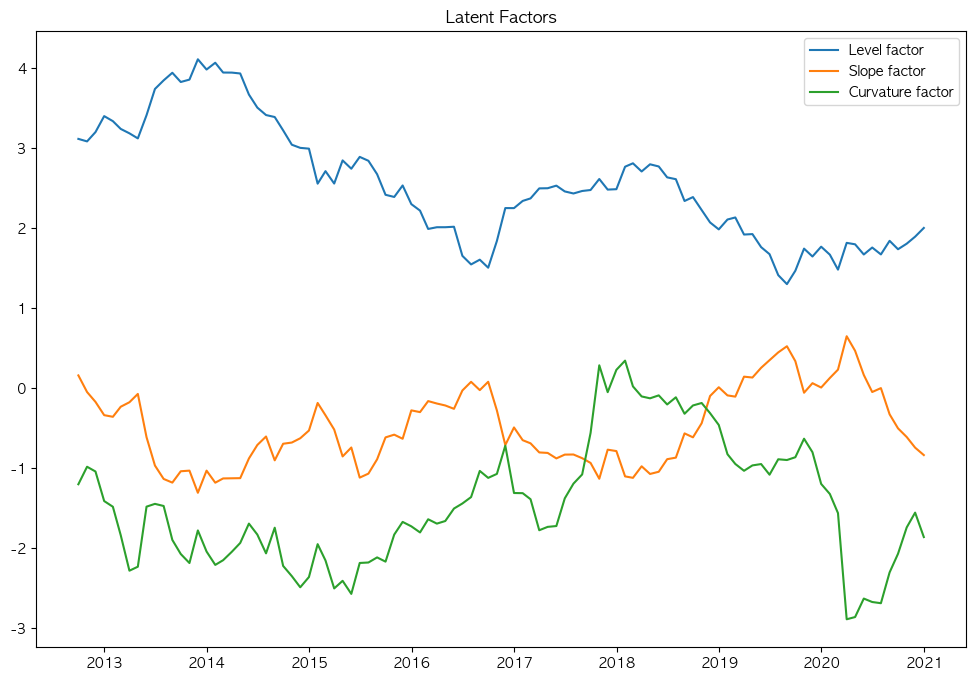

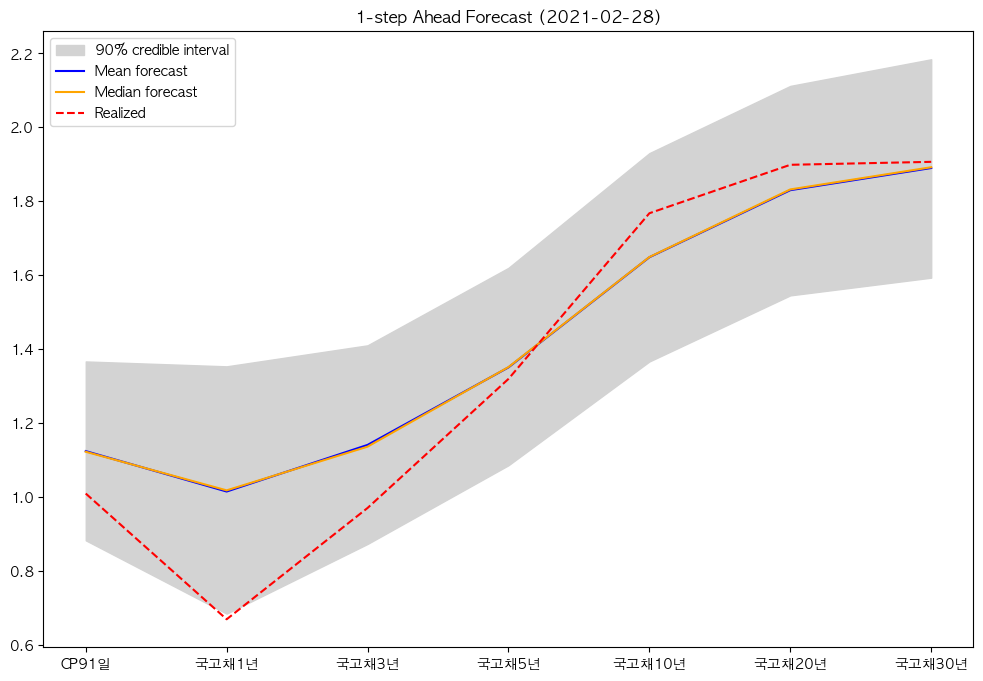

In [7]:
forecast_result, parameter_dict_list, factor_list=run_dynamic_nelson_sigel(bond_yield_train)
plot_forecast(forecast_result, factor_list)

(c) 2021년 3월, 6월의 수익률 곡선의 사후 예측 분포 샘플링 과정을 설명하고, 실제 샘플링한 결과를 그림으로 나타내시오

100%|██████████| 3000/3000 [00:29<00:00, 100.97it/s]


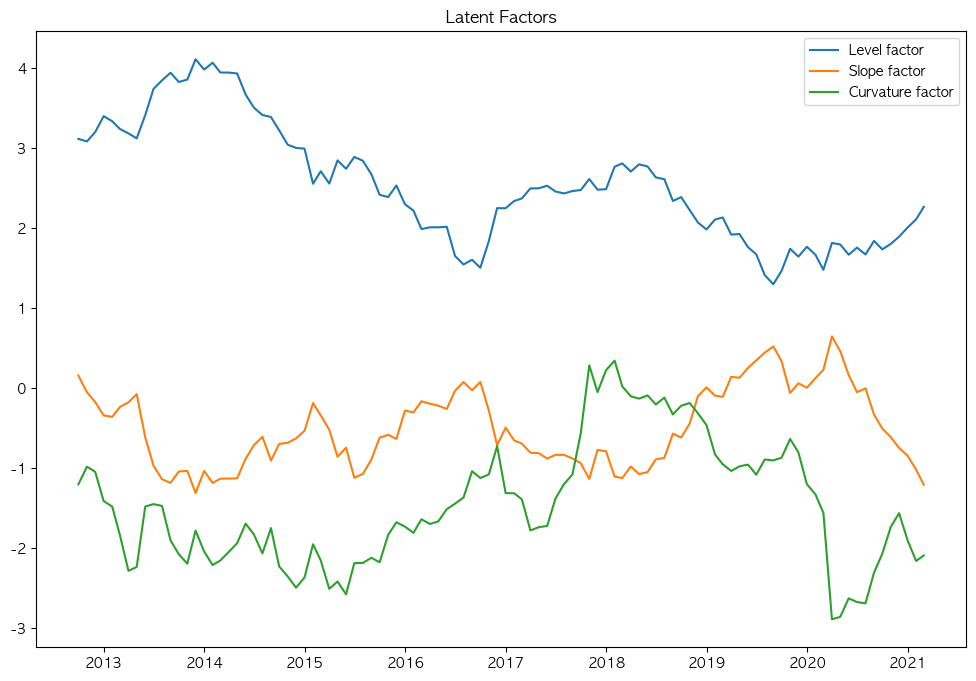

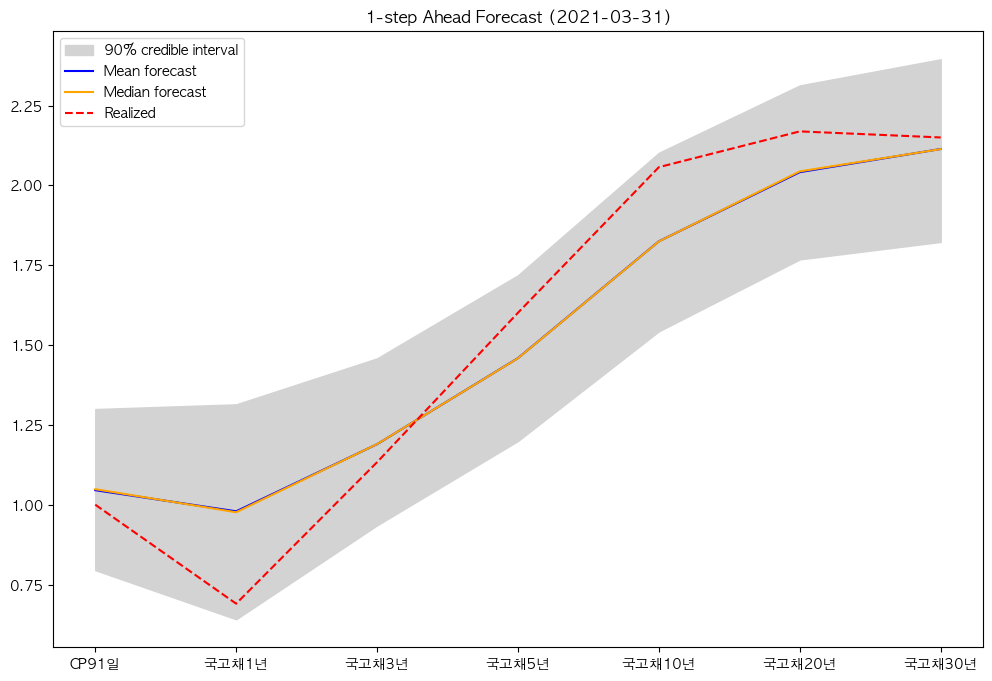

100%|██████████| 3000/3000 [00:30<00:00, 97.27it/s] 


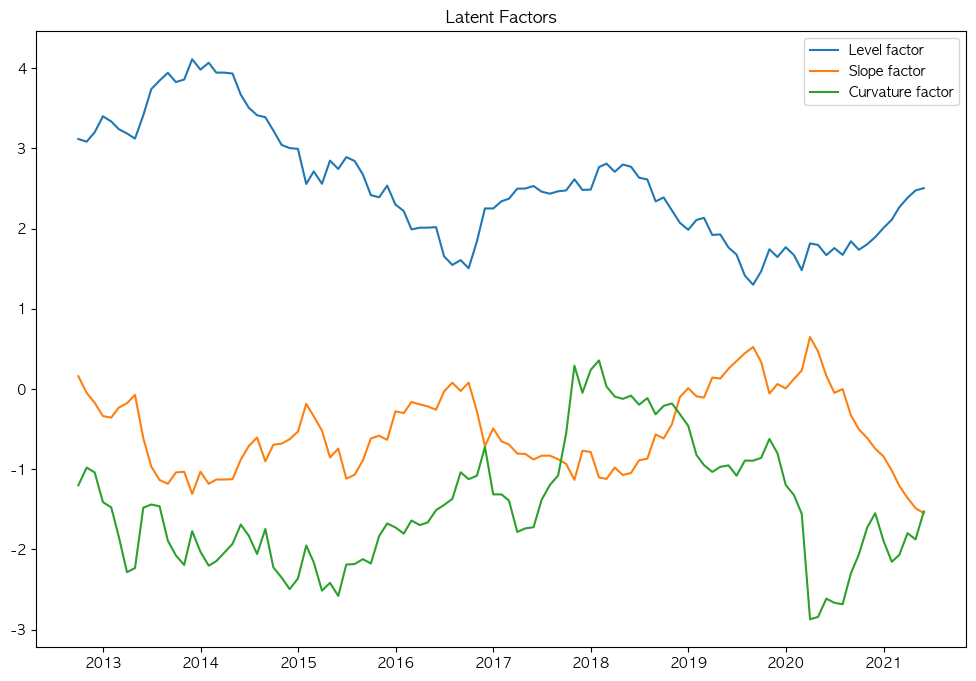

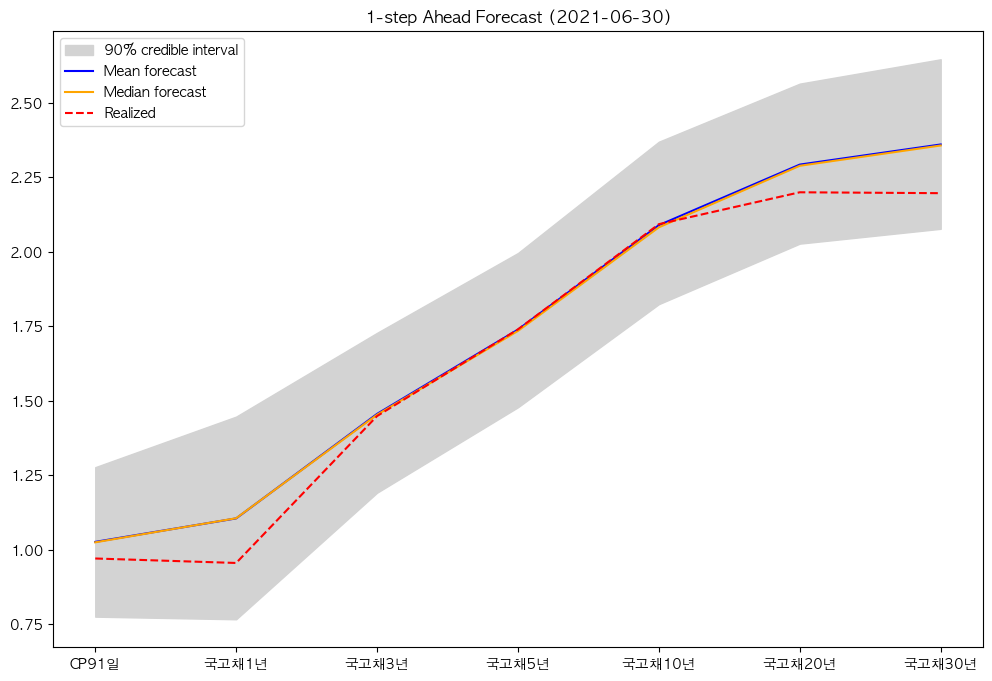

In [8]:
import datetime

for end_time in ['2021-02-28', '2021-05-31']:
    dt=datetime.datetime.strptime(end_time, '%Y-%m-%d')
    forecast_time=dt+pd.offsets.MonthEnd(1)
    forecast_time=forecast_time.strftime('%Y-%m-%d')
    bond_yield=pd.read_csv('./data/korea_bond_yield.csv', index_col=0)
    bond_yield.index=pd.to_datetime(bond_yield.index)
    bond_yield.index=bond_yield.index
    bond_yield=bond_yield.astype(np.float64)
    bond_yield_train=bond_yield[bond_yield.index<=end_time]
    bond_yield_test=bond_yield[bond_yield.index>end_time]

    forecast_result, parameter_dict_list, factor_list=run_dynamic_nelson_sigel(bond_yield_train, burn_in=1000, n_samples=2000)
    plot_forecast(forecast_result, factor_list, target_date=forecast_time)

(d) 잠재요인이 3개가 아니라 2개인 경우(수준과 기울기 요인)에도 실행되도록 코드를 작성하여 2021년 1월의 사후 예측 밀도를 계산하고 (b)와 비교하시오

설명력이 떨어졌으며 curvative 요인에 사라짐에 따라서 장기적인쪽의 오차가 더욱증가하였다.

100%|██████████| 3000/3000 [00:25<00:00, 118.37it/s]


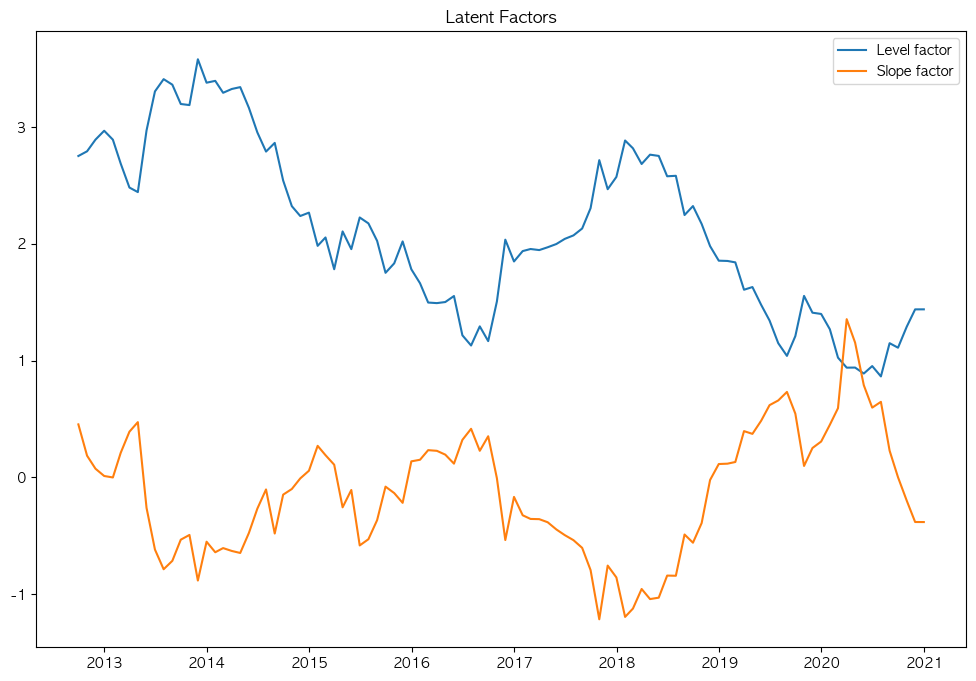

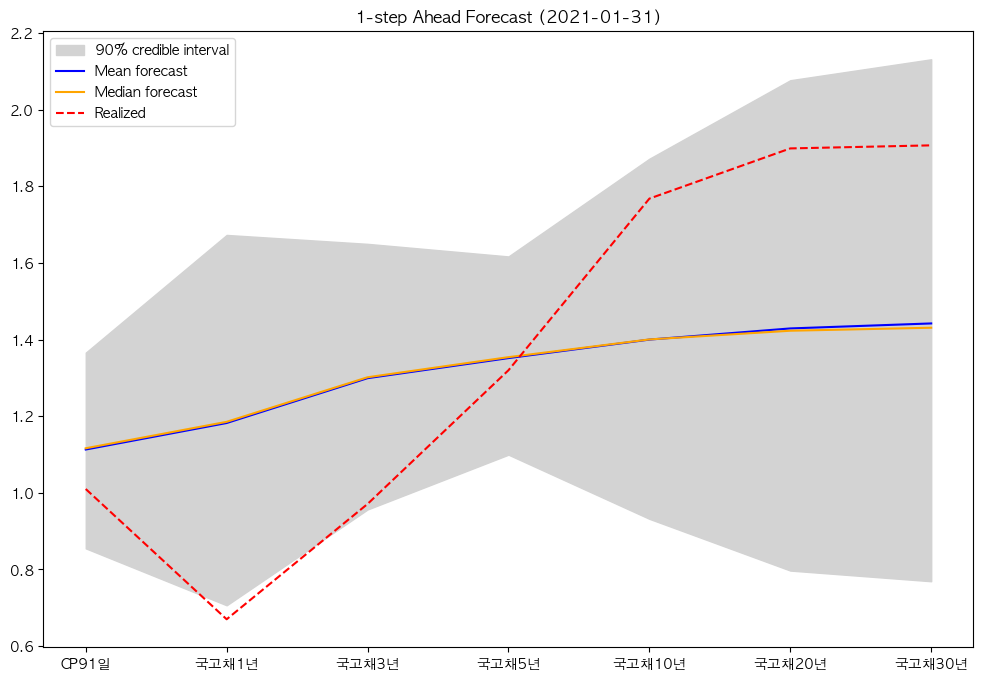

: 

: 

In [ ]:
for end_time in ['2020-12-31']:
    dt=datetime.datetime.strptime(end_time, '%Y-%m-%d')
    forecast_time=dt+pd.offsets.MonthEnd(1)
    forecast_time=forecast_time.strftime('%Y-%m-%d')
    bond_yield=pd.read_csv('./data/korea_bond_yield.csv', index_col=0)
    bond_yield.index=pd.to_datetime(bond_yield.index)
    bond_yield.index=bond_yield.index
    bond_yield=bond_yield.astype(np.float64)
    bond_yield_train=bond_yield[bond_yield.index<=end_time]
    bond_yield_test=bond_yield[bond_yield.index>end_time]

    forecast_result, parameter_dict_list, factor_list=run_dynamic_nelson_sigel(bond_yield_train, latent_factor_idx=[0, 1], burn_in=1000, n_samples=2000)
    plot_forecast(forecast_result, factor_list, target_date=forecast_time)